# X–θ NIST: Loop-direction (CW vs CCW) test using settings-path holonomy

We treat θ as a _context holonomy_ derived from the time-ordered settings stream.
We detect closed square loops in (a,b) control space:

- CW loop: 00→01→11→10→00
- CCW loop: 00→10→11→01→00

Then we test whether Bell statistic J differs between CW-like vs CCW-like contexts.

Null: outcomes are shuffled within (time block × setting pair), labels fixed.


In [ ]:
import os, json
from dataclasses import dataclass
from typing import Dict, Any, Optional, Tuple

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

## Download one real run HDF5 (not the training file)

Pick a `.compressed.build.hdf5` file from NIST's processed_compressed/hdf5 listing (typically 0.7–1.3 GB).
We need per-trial:

- alice/settings, bob/settings
- alice/_click_, bob/_click_ (uint16, length ~ settings)

If click masks are missing, this notebook will stop early (by design).


In [ ]:
@dataclass
class CFG:
    # Pick ONE real run first (examples exist on NIST listing page)
    URL: str = (
        "https://s3.amazonaws.com/nist-belltestdata/belldata/processed_compressed/hdf5/2015_09_18/"
        "02_54_CH_pockel_100kHz.run4.afterTimingfix2.dat.compressed.build.hdf5"
    )
    HDF5_PATH: str = "./data_v5_nist/nist_run.build.hdf5"

    # Slice:
    START: int = 0
    MAX_TRIALS: Optional[int] = 3_000_000  # None = full

    # Theta/loop config:
    THETA_BINS: int = 12
    THETA_WRAP_2PI: bool = True

    # Loop detection:
    LOOP_TURN_TOL: float = 0.75 * np.pi  # accept | |Δturn|-2π | < tol

    # Permutation (drift-preserving):
    BLOCK_SIZE: int = 20_000
    PERM_ROUNDS: int = 200
    SEED: int = 123

    # Binning sanity:
    MIN_VALID_PER_BIN: int = 20_000


CFG = CFG()
os.makedirs(os.path.dirname(CFG.HDF5_PATH), exist_ok=True)
print("Saving to:", CFG.HDF5_PATH)


def download_with_resume(url: str, out_path: str, chunk_size: int = 8 * 1024 * 1024):
    import requests

    headers = {}
    mode = "wb"
    if os.path.exists(out_path):
        existing = os.path.getsize(out_path)
        headers["Range"] = f"bytes={existing}-"
        mode = "ab"
        print(f"Resuming at byte {existing:,}")
    else:
        print("Starting fresh download")

    with requests.get(url, stream=True, headers=headers, timeout=60) as r:
        r.raise_for_status()
        with open(out_path, mode) as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)


if not os.path.exists(CFG.HDF5_PATH):
    download_with_resume(CFG.URL, CFG.HDF5_PATH)
else:
    print("File exists; skipping download.")

Saving to: ./data_v5_nist/nist_run.build.hdf5
Starting fresh download


## Scan HDF5 and auto-pick settings + click-mask datasets

We _require_ per-trial click masks (uint16 arrays with length ≈ settings length).
If the file only contains settings/metadata, this cell will raise an error.


,path,shape,dtype,ndim,n0,path_l
0,config/alice/bitoffset,(),int64,0,1,config/alice/bitoffset
1,config/alice/pk,(),int64,0,1,config/alice/pk
2,config/alice/radius,(),int64,0,1,config/alice/radius
3,config/bob/bitoffset,(),int64,0,1,config/bob/bitoffset
4,config/bob/pk,(),int64,0,1,config/bob/pk
5,config/bob/radius,(),int64,0,1,config/bob/radius
6,offsets/firstsync/alice,(),int64,0,1,offsets/firstsync/alice
7,offsets/firstsync/bob,(),int64,0,1,offsets/firstsync/bob
8,offsets/lastidx/alice,(),int64,0,1,offsets/lastidx/alice
9,offsets/lastidx/bob,(),int64,0,1,offsets/lastidx/bob


{
  "a_set": "alice/settings",
  "b_set": "bob/settings",
  "a_click": "alice/clicks",
  "b_click": "bob/clicks",
  "a_firstsync": "offsets/firstsync/alice",
  "b_firstsync": "offsets/firstsync/bob",
  "a_lastidx": "offsets/lastidx/alice",
  "b_lastidx": "offsets/lastidx/bob"
}
{'a_bitoffset': 28, 'a_pk': 90, 'a_radius': 4, 'b_bitoffset': 37, 'b_pk': 125, 'b_radius': 5}
slotA: unique(min..max) = -1 15
slotB: unique(min..max) = -1 15
nonzero clicks: 4035 4290


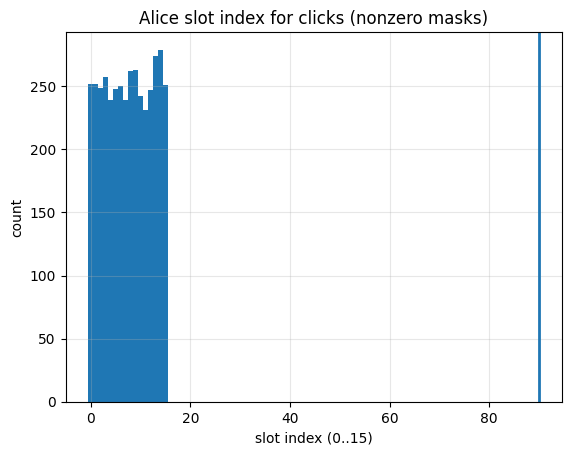

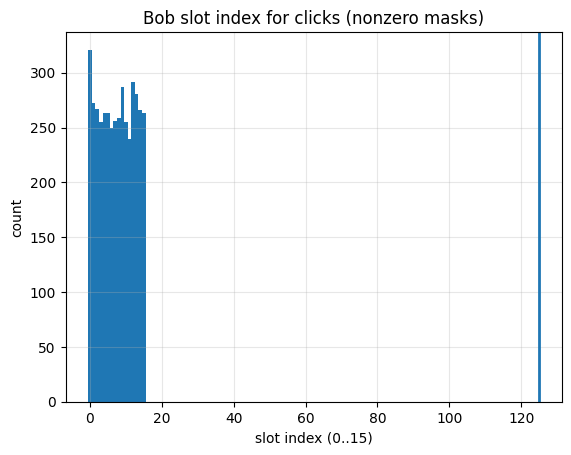

In [11]:
def scan_hdf5_datasets(hdf5_path: str) -> pd.DataFrame:
    rows = []
    with h5py.File(hdf5_path, "r") as h5:

        def walk(name, obj):
            if isinstance(obj, h5py.Dataset):
                shape = obj.shape
                rows.append(
                    {
                        "path": name,
                        "shape": shape,
                        "dtype": str(obj.dtype),
                        "ndim": len(shape),
                        "n0": int(shape[0]) if len(shape) >= 1 else 1,
                    }
                )

        h5.visititems(walk)
    df = pd.DataFrame(rows)
    df["path_l"] = df["path"].str.lower()
    return df.sort_values(["ndim", "n0"], ascending=[True, False]).reset_index(
        drop=True
    )


df_ds = scan_hdf5_datasets(CFG.HDF5_PATH)
display(df_ds.head(60))

# def pick_required_paths(df_ds: pd.DataFrame) -> Dict[str, str]:
#     out = {}

#     # settings
#     if (df_ds["path"] == "alice/settings").any():
#         out["a_set"] = "alice/settings"
#     if (df_ds["path"] == "bob/settings").any():
#         out["b_set"] = "bob/settings"
#     if "a_set" not in out or "b_set" not in out:
#         cand = df_ds[(df_ds["ndim"] == 1) & (df_ds["path_l"].str.contains("setting"))]
#         cand = cand.sort_values("n0", ascending=False)
#         if len(cand) < 2:
#             raise RuntimeError("Could not find two settings datasets.")
#         out["a_set"] = cand.iloc[0]["path"]
#         out["b_set"] = cand.iloc[1]["path"]

#     # click masks
#     a_n = int(df_ds.loc[df_ds["path"] == out["a_set"], "n0"].iloc[0])
#     b_n = int(df_ds.loc[df_ds["path"] == out["b_set"], "n0"].iloc[0])
#     N_common = min(a_n, b_n)
#     TOL = 5000

#     cand_click = df_ds[
#         (df_ds["ndim"] == 1)
#         & (df_ds["dtype"].str.contains("uint16"))
#         & (df_ds["n0"].between(N_common - TOL, N_common + TOL))
#         & (df_ds["path_l"].str.contains("click"))
#     ].copy()

#     a_click = cand_click[cand_click["path_l"].str.contains("alice")]
#     b_click = cand_click[cand_click["path_l"].str.contains("bob")]

#     if len(a_click) >= 1 and len(b_click) >= 1:
#         out["a_click"] = a_click.sort_values("n0", ascending=False).iloc[0]["path"]
#         out["b_click"] = b_click.sort_values("n0", ascending=False).iloc[0]["path"]
#         return out

#     raise RuntimeError(
#         "No per-trial click masks found (uint16, length~settings, path contains 'click').\n"
#         "Switch CFG.URL to a different real-run file and re-run."
#     )

# paths = pick_required_paths(df_ds)
# print(json.dumps(paths, indent=2))


def pick_required_paths_v2(df_ds: pd.DataFrame) -> Dict[str, str]:
    out = {}
    # settings
    if (df_ds["path"] == "alice/settings").any():
        out["a_set"] = "alice/settings"
    else:
        raise RuntimeError("Missing alice/settings")

    if (df_ds["path"] == "bob/settings").any():
        out["b_set"] = "bob/settings"
    else:
        raise RuntimeError("Missing bob/settings")

    # clicks (prefer exact names)
    if (df_ds["path"] == "alice/clicks").any():
        out["a_click"] = "alice/clicks"
    else:
        cand = df_ds[
            df_ds["path_l"].str.contains("alice")
            & df_ds["path_l"].str.contains("click")
        ]
        if len(cand) == 0:
            raise RuntimeError("Missing alice clicks dataset")
        out["a_click"] = cand.iloc[0]["path"]

    if (df_ds["path"] == "bob/clicks").any():
        out["b_click"] = "bob/clicks"
    else:
        cand = df_ds[
            df_ds["path_l"].str.contains("bob") & df_ds["path_l"].str.contains("click")
        ]
        if len(cand) == 0:
            raise RuntimeError("Missing bob clicks dataset")
        out["b_click"] = cand.iloc[0]["path"]

    # optional offsets
    out["a_firstsync"] = (
        "offsets/firstsync/alice"
        if (df_ds["path"] == "offsets/firstsync/alice").any()
        else ""
    )
    out["b_firstsync"] = (
        "offsets/firstsync/bob"
        if (df_ds["path"] == "offsets/firstsync/bob").any()
        else ""
    )
    out["a_lastidx"] = (
        "offsets/lastidx/alice"
        if (df_ds["path"] == "offsets/lastidx/alice").any()
        else ""
    )
    out["b_lastidx"] = (
        "offsets/lastidx/bob" if (df_ds["path"] == "offsets/lastidx/bob").any() else ""
    )

    return out


paths = pick_required_paths_v2(df_ds)
print(json.dumps(paths, indent=2))


import matplotlib.pyplot as plt

with h5py.File(CFG.HDF5_PATH, "r") as h5:
    meta = {
        "a_bitoffset": int(h5["config/alice/bitoffset"][()]),
        "a_pk": int(h5["config/alice/pk"][()]),
        "a_radius": int(h5["config/alice/radius"][()]),
        "b_bitoffset": int(h5["config/bob/bitoffset"][()]),
        "b_pk": int(h5["config/bob/pk"][()]),
        "b_radius": int(h5["config/bob/radius"][()]),
    }
print(meta)


# LUT: mask -> bit index in [0..15], else -1
LUT = np.full(1 << 16, -1, dtype=np.int8)
for k in range(16):
    LUT[1 << k] = k

slotA = LUT[a_click.astype(np.uint16)]
slotB = LUT[b_click.astype(np.uint16)]

# sanity
print("slotA: unique(min..max) =", int(slotA.min()), int(slotA.max()))
print("slotB: unique(min..max) =", int(slotB.min()), int(slotB.max()))
print("nonzero clicks:", int((slotA >= 0).sum()), int((slotB >= 0).sum()))

# hist of slots for nonzero
plt.figure()
plt.hist(slotA[slotA >= 0], bins=np.arange(-0.5, 16.5, 1))
plt.axvline(meta["a_pk"], linewidth=2)
plt.title("Alice slot index for clicks (nonzero masks)")
plt.xlabel("slot index (0..15)")
plt.ylabel("count")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.hist(slotB[slotB >= 0], bins=np.arange(-0.5, 16.5, 1))
plt.axvline(meta["b_pk"], linewidth=2)
plt.title("Bob slot index for clicks (nonzero masks)")
plt.xlabel("slot index (0..15)")
plt.ylabel("count")
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
def circular_dist_16(x, c):
    # x in [0..15], returns distance on a 16-cycle to center c
    d = (x - c) % 16
    return np.minimum(d, 16 - d)


# base: any click is a detection
A_det_any = (a_click != 0).astype(np.int8)
B_det_any = (b_click != 0).astype(np.int8)

# gated: only accept clicks within radius of pk (on the 16-slot cycle)
A_valid = (slotA >= 0) & (circular_dist_16(slotA, meta["a_pk"]) <= meta["a_radius"])
B_valid = (slotB >= 0) & (circular_dist_16(slotB, meta["b_pk"]) <= meta["b_radius"])
A_det_gate = A_valid.astype(np.int8)
B_det_gate = B_valid.astype(np.int8)


def rates(A_det, B_det):
    return {
        "Alice_det": float(A_det.mean()),
        "Bob_det": float(B_det.mean()),
        "Coinc": float((A_det & B_det).mean()),
        "Both_miss": float(((1 - A_det) & (1 - B_det)).mean()),
    }


print("Rates using ANY click:", rates(A_det_any, B_det_any))
print("Rates using pk/radius gate:", rates(A_det_gate, B_det_gate))

Rates using ANY click: {'Alice_det': 0.001345, 'Bob_det': 0.00143, 'Coinc': 0.00034033333333333333, 'Both_miss': 0.9975653333333333}
Rates using pk/radius gate: {'Alice_det': 0.0007623333333333333, 'Bob_det': 0.001001, 'Coinc': 0.000153, 'Both_miss': 0.9983896666666666}


In [13]:
def eberhard_J_from_arrays(a_set, b_set, A_det, B_det, swap_a=False, swap_b=False):
    a = (1 - a_set) if swap_a else a_set
    b = (1 - b_set) if swap_b else b_set

    # probs helper
    def probs(aa, bb):
        m = (a == aa) & (b == bb)
        n = int(m.sum())
        if n == 0:
            return (np.nan, np.nan, np.nan)
        Am = A_det[m]
        Bm = B_det[m]
        p11 = float(np.mean((Am == 1) & (Bm == 1)))
        p10 = float(np.mean((Am == 1) & (Bm == 0)))
        p01 = float(np.mean((Am == 0) & (Bm == 1)))
        return p11, p10, p01

    p11_a1b1, _, _ = probs(0, 0)
    _, p10_a1b2, _ = probs(0, 1)
    _, _, p01_a2b1 = probs(1, 0)
    p11_a2b2, _, _ = probs(1, 1)

    return float(p11_a1b1 - p10_a1b2 - p01_a2b1 - p11_a2b2)


def scan_label_swaps(a_set, b_set, A_det, B_det):
    out = []
    for sa in [False, True]:
        for sb in [False, True]:
            J = eberhard_J_from_arrays(a_set, b_set, A_det, B_det, swap_a=sa, swap_b=sb)
            out.append((sa, sb, J))
    out.sort(key=lambda t: t[2], reverse=True)
    return out


# choose which detection definition to use:
A_det = A_det_gate
B_det = B_det_gate

cand = scan_label_swaps(a_set, b_set, A_det, B_det)
for sa, sb, J in cand:
    print(f"swap_a={sa}, swap_b={sb}  ->  J = {J:.6e}")

best_swap_a, best_swap_b, best_J = cand[0]
print("\nBEST labeling:", {"swap_a": best_swap_a, "swap_b": best_swap_b, "J": best_J})

swap_a=False, swap_b=False  ->  J = -1.435210e-03
swap_a=True, swap_b=True  ->  J = -1.448451e-03
swap_a=False, swap_b=True  ->  J = -1.468873e-03
swap_a=True, swap_b=False  ->  J = -1.476778e-03

BEST labeling: {'swap_a': False, 'swap_b': False, 'J': -0.001435210050264053}


## Load arrays (align Alice/Bob lengths, then slice)

We trim to N_common and then apply START/MAX_TRIALS.
We remap settings values to {0,1} based on the two most frequent values.


In [ ]:
def load_scalar_if_exists(h5: h5py.File, path: str, default: int) -> int:
    if path and path in h5:
        return int(h5[path][()])
    return int(default)


def remap_two_state_to_01(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    vals, cnt = np.unique(x, return_counts=True)
    order = np.argsort(cnt)[::-1]
    if len(order) < 2:
        return np.full(x.shape, -1, dtype=np.int8)
    v0, v1 = vals[order[0]], vals[order[1]]
    out = np.full(x.shape, -1, dtype=np.int8)
    out[x == v0] = 0
    out[x == v1] = 1
    return out


def load_slice_arrays_v2(
    hdf5_path: str, paths: Dict[str, str], start: int, max_trials: Optional[int]
):
    with h5py.File(hdf5_path, "r") as h5:
        a_set_ds = h5[paths["a_set"]]
        b_set_ds = h5[paths["b_set"]]
        a_clk_ds = h5[paths["a_click"]]
        b_clk_ds = h5[paths["b_click"]]

        # offsets that map click index -> settings index (hypothesis)
        a0 = load_scalar_if_exists(h5, paths.get("a_firstsync", ""), default=0)
        b0 = load_scalar_if_exists(h5, paths.get("b_firstsync", ""), default=0)

        a_last = load_scalar_if_exists(
            h5, paths.get("a_lastidx", ""), default=a_set_ds.shape[0]
        )
        b_last = load_scalar_if_exists(
            h5, paths.get("b_lastidx", ""), default=b_set_ds.shape[0]
        )

        # how many settings indices are "valid" after offsets
        a_valid = max(0, min(a_last, a_set_ds.shape[0]) - a0)
        b_valid = max(0, min(b_last, b_set_ds.shape[0]) - b0)

        # click arrays are the hard limit (both are same length in your file)
        click_len = min(a_clk_ds.shape[0], b_clk_ds.shape[0])

        # usable trials = min(click_len, a_valid, b_valid)
        N_total = min(click_len, a_valid, b_valid)

        s0 = int(start)
        s1 = int(N_total if max_trials is None else min(N_total, start + max_trials))
        if s0 >= s1:
            raise RuntimeError(f"Empty slice: start={s0}, end={s1}, N_total={N_total}")

        # load clicks slice
        a_click = a_clk_ds[s0:s1].astype(np.uint16)
        b_click = b_clk_ds[s0:s1].astype(np.uint16)

        # load aligned settings slice
        a_raw = a_set_ds[a0 + s0 : a0 + s1]
        b_raw = b_set_ds[b0 + s0 : b0 + s1]

    # remap settings to {0,1}
    a = remap_two_state_to_01(a_raw).astype(np.int8)
    b = remap_two_state_to_01(b_raw).astype(np.int8)

    ok = (a >= 0) & (b >= 0)
    a = a[ok]
    b = b[ok]
    a_click = a_click[ok]
    b_click = b_click[ok]

    debug = {
        "a0_firstsync": a0,
        "b0_firstsync": b0,
        "a_lastidx": a_last,
        "b_lastidx": b_last,
        "a_valid": a_valid,
        "b_valid": b_valid,
        "click_len": click_len,
        "N_total_used": N_total,
        "slice": (s0, s1),
        "after_ok_len": int(len(a)),
    }
    return a, b, a_click, b_click, debug


a_set, b_set, a_click, b_click, dbg = load_slice_arrays_v2(
    CFG.HDF5_PATH, paths, CFG.START, CFG.MAX_TRIALS
)
print(json.dumps(dbg, indent=2))
print("Loaded N:", len(a_set))
print("a unique:", np.unique(a_set), "b unique:", np.unique(b_set))
print("click nonzero frac:", float(np.mean(a_click != 0)), float(np.mean(b_click != 0)))

{
  "a0_firstsync": 232706,
  "b0_firstsync": 270536,
  "a_lastidx": 436883651,
  "b_lastidx": 435269593,
  "a_valid": 213236909,
  "b_valid": 213199072,
  "click_len": 203681462,
  "N_total_used": 203681462,
  "slice": [
    0,
    3000000
  ],
  "after_ok_len": 3000000
}
Loaded N: 3000000
a unique: [0 1] b unique: [0 1]
click nonzero frac: 0.001345 0.00143


## Decode outcomes

First-pass detection model:
A_det = 1 if (alice_click_mask != 0) else 0
B_det = 1 if (bob_click_mask != 0) else 0

This supports CH/Eberhard-style J.


Alice detection rate: 0.001345
Bob detection rate: 0.00143
Coincidence rate: 0.00034033333333333333
Both-miss rate: 0.9975653333333333
A popcount: min/median/p95/max = 0 0.0 0.0 1
B popcount: min/median/p95/max = 0 0.0 0.0 1


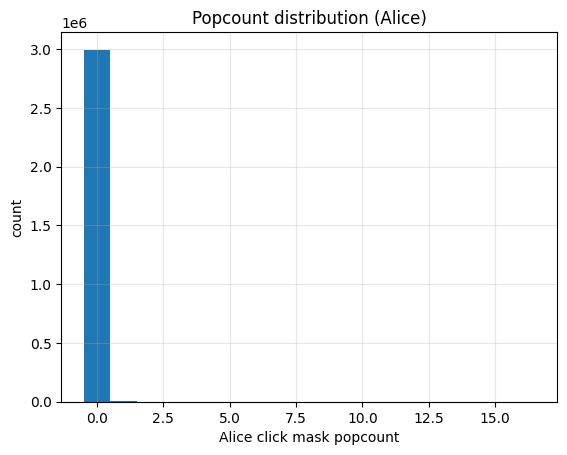

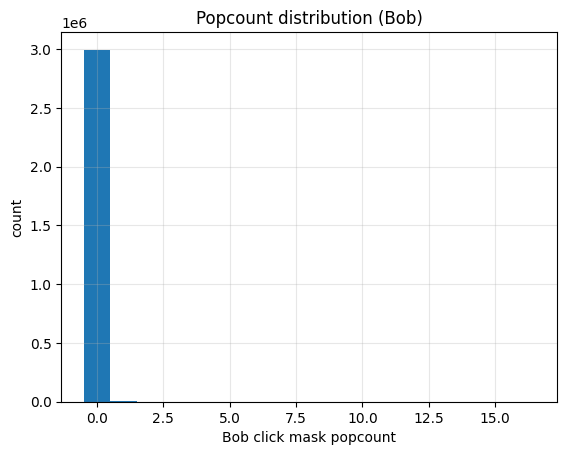

In [8]:
A_det = (a_click != 0).astype(np.int8)
B_det = (b_click != 0).astype(np.int8)

print("Alice detection rate:", float(A_det.mean()))
print("Bob detection rate:", float(B_det.mean()))
print("Coincidence rate:", float(np.mean((A_det == 1) & (B_det == 1))))
print("Both-miss rate:", float(np.mean((A_det == 0) & (B_det == 0))))


# Popcount (number of 1-bits) for each uint16 click mask


def popcount_u16(arr_u16: np.ndarray) -> np.ndarray:
    arr_u16 = np.asarray(arr_u16, dtype=np.uint16)

    # Fast path: NumPy ufunc (available in newer numpy versions)
    if hasattr(np, "bit_count"):
        return np.bit_count(arr_u16).astype(np.uint8)

    # Fallback: lookup table for all 16-bit values
    lut = np.array([bin(i).count("1") for i in range(1 << 16)], dtype=np.uint8)
    return lut[arr_u16]


pcA = popcount_u16(a_click)
pcB = popcount_u16(b_click)

print(
    "A popcount: min/median/p95/max =",
    int(pcA.min()),
    float(np.median(pcA)),
    float(np.percentile(pcA, 95)),
    int(pcA.max()),
)
print(
    "B popcount: min/median/p95/max =",
    int(pcB.min()),
    float(np.median(pcB)),
    float(np.percentile(pcB, 95)),
    int(pcB.max()),
)

plt.figure()
plt.hist(pcA, bins=np.arange(0, 18), align="left")
plt.xlabel("Alice click mask popcount")
plt.ylabel("count")
plt.title("Popcount distribution (Alice)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.hist(pcB, bins=np.arange(0, 18), align="left")
plt.xlabel("Bob click mask popcount")
plt.ylabel("count")
plt.title("Popcount distribution (Bob)")
plt.grid(True, alpha=0.3)
plt.show()

## Build θ from transition-compressed settings (path-only)

We compress repeated settings, so θ only changes when (a,b) changes.
Then we detect closed 4-step square loops in the compressed path.
For each detected loop:

- Δturn ≈ -2π => CW
- Δturn ≈ +2π => CCW

We label the _center vertex_ of each loop (on the compressed path),
then map those labels back to the original trial indices.


In [ ]:
def setting_code(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    return ((a.astype(np.uint8) << 1) | b.astype(np.uint8)).astype(
        np.uint8
    )  # 00,01,10,11 -> 0,1,2,3


def outcome_code(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    return ((A.astype(np.uint8) << 1) | B.astype(np.uint8)).astype(
        np.uint8
    )  # 00..11 -> 0..3


# corners for codes 0..3: 00,01,10,11
# we want square corners: 00(-1,-1), 01(-1,+1), 10(+1,-1), 11(+1,+1)
corner_by_code = np.array([-1 - 1j, -1 + 1j, +1 - 1j, +1 + 1j], dtype=np.complex128)


def compute_theta_transition_compressed(a, b, wrap_2pi=True):
    s = setting_code(a, b)
    change = np.ones(len(s), dtype=bool)
    change[1:] = s[1:] != s[:-1]
    idxc = np.where(change)[0]  # original indices of compressed points
    sc = s[change]  # compressed setting code
    zc = corner_by_code[sc]  # compressed corners as complex

    # cumulative turning (unwrapped) on compressed path
    cum = np.zeros(len(zc), dtype=np.float64)
    if len(zc) >= 3:
        v = np.diff(zc)
        ang = np.angle(v[1:] * np.conj(v[:-1]))  # turns at interior points
        cum[2:] = np.cumsum(ang)

    # theta on compressed points, optionally wrapped
    theta_c = np.mod(cum, 2 * np.pi) if wrap_2pi else cum.copy()

    # broadcast to full trials (piecewise constant between changes)
    theta_full = np.empty(len(s), dtype=np.float64)
    theta_full[idxc] = theta_c
    theta_full = pd.Series(theta_full).ffill().fillna(0.0).to_numpy()

    return theta_full, idxc, sc, zc, cum


theta, idxc, sc, zc, cum_turn = compute_theta_transition_compressed(
    a_set, b_set, wrap_2pi=CFG.THETA_WRAP_2PI
)
print("theta min/max:", float(theta.min()), float(theta.max()))
print("compressed points:", len(idxc))


def label_square_loops(
    sc: np.ndarray, zc: np.ndarray, cum_turn: np.ndarray, tol: float
) -> np.ndarray:
    """
    Returns labels on compressed points:
      0 = none
     -1 = CW (Δturn ≈ -2π)
     +1 = CCW (Δturn ≈ +2π)
    """
    n = len(zc)
    labels_c = np.zeros(n, dtype=np.int8)
    if n < 5:
        return labels_c

    L = 4  # 4 steps => 5 points
    starts = np.arange(0, n - L)
    ends = starts + L

    closed = zc[starts] == zc[ends]
    delta = cum_turn[ends] - cum_turn[starts]
    loopish = closed & (np.abs(np.abs(delta) - 2 * np.pi) < tol)

    cand = np.where(loopish)[0]
    for k in cand:
        i = starts[k]
        seg = sc[i : i + 5]
        if len(np.unique(seg)) != 4:
            continue  # reject degenerate "closed" paths that didn't hit all corners
        d = delta[k]
        if d < 0:
            labels_c[i + 2] = -1  # CW (right turns)
        elif d > 0:
            labels_c[i + 2] = +1  # CCW (left turns)

    return labels_c


labels_c = label_square_loops(sc, zc, cum_turn, tol=CFG.LOOP_TURN_TOL)

# Map labels back to full trial indices: only at change points
labels_full = np.zeros(len(a_set), dtype=np.int8)
labels_full[idxc] = labels_c

print("CW labeled points:", int(np.sum(labels_c == -1)))
print("CCW labeled points:", int(np.sum(labels_c == +1)))

## Compute Eberhard/CH-style J for:

- all trials
- CW-labeled trials
- CCW-labeled trials

J = p11(0,0) - p10(0,1) - p01(1,0) - p11(1,1)

We compute J from counts to avoid slow pandas loops.


In [ ]:
def compute_J_from_counts(counts_setting_outcome: np.ndarray) -> float:
    # counts_setting_outcome shape: (4 settings, 4 outcomes)
    def p(s, o):
        n = counts_setting_outcome[s].sum()
        return np.nan if n == 0 else counts_setting_outcome[s, o] / n

    p11_a1b1 = p(0, 3)  # (0,0) outcome 11
    p10_a1b2 = p(1, 2)  # (0,1) outcome 10
    p01_a2b1 = p(2, 1)  # (1,0) outcome 01
    p11_a2b2 = p(3, 3)  # (1,1) outcome 11
    return float(p11_a1b1 - p10_a1b2 - p01_a2b1 - p11_a2b2)


def J_on_indices(a, b, A, B, idx: np.ndarray) -> Tuple[float, int]:
    s = setting_code(a[idx], b[idx]).astype(np.int64)
    o = outcome_code(A[idx], B[idx]).astype(np.int64)
    key = s * 4 + o
    bc = np.bincount(key, minlength=16).reshape(4, 4)
    return compute_J_from_counts(bc), int(len(idx))


# indices
idx_all = np.arange(len(a_set), dtype=np.int64)
idx_cw = np.where(labels_full == -1)[0].astype(np.int64)
idx_ccw = np.where(labels_full == +1)[0].astype(np.int64)

J_all, n_all = J_on_indices(a_set, b_set, A_det, B_det, idx_all)
J_cw, n_cw = (
    J_on_indices(a_set, b_set, A_det, B_det, idx_cw) if len(idx_cw) else (np.nan, 0)
)
J_ccw, n_ccw = (
    J_on_indices(a_set, b_set, A_det, B_det, idx_ccw) if len(idx_ccw) else (np.nan, 0)
)

print(f"J(all)  = {J_all:.6e}   n={n_all:,}")
print(f"J(CW)   = {J_cw:.6e}   n={n_cw:,}")
print(f"J(CCW)  = {J_ccw:.6e}   n={n_ccw:,}")

delta_J = float(J_cw - J_ccw) if np.isfinite(J_cw) and np.isfinite(J_ccw) else np.nan
print(f"ΔJ = J(CW) - J(CCW) = {delta_J:.6e}")

## Drift-preserving permutation test for ΔJ

Labels are derived from settings history, so we keep them fixed.

Null:
Shuffle the JOINT outcomes (A,B) within each:

- time block
- setting pair (a,b)

Then recompute ΔJ on the same CW/CCW-labeled indices.

Two-sided p-value: P(|ΔJ_null| >= |ΔJ_obs|)


In [ ]:
def permute_joint_outcomes_blockwise(
    a, b, out_code, block_size: int, rng: np.random.Generator
) -> np.ndarray:
    n = len(out_code)
    outp = out_code.copy()
    s = setting_code(a, b)

    for start in range(0, n, block_size):
        end = min(n, start + block_size)
        sb = s[start:end]
        for scode in range(4):
            idx_local = np.where(sb == scode)[0]
            if idx_local.size > 2:
                idx = idx_local + start
                outp[idx] = rng.permutation(outp[idx])
    return outp


def perm_test_deltaJ(a, b, A, B, idx_cw, idx_ccw, block_size, perm_rounds, seed=123):
    rng = np.random.default_rng(seed)
    out = outcome_code(A, B)

    # observed
    J_cw_obs, _ = J_on_indices(a, b, A, B, idx_cw) if len(idx_cw) else (np.nan, 0)
    J_ccw_obs, _ = J_on_indices(a, b, A, B, idx_ccw) if len(idx_ccw) else (np.nan, 0)
    d_obs = float(J_cw_obs - J_ccw_obs)

    null = np.full(perm_rounds, np.nan, dtype=np.float64)
    for r in range(perm_rounds):
        outp = permute_joint_outcomes_blockwise(a, b, out, block_size, rng)
        Ap = ((outp >> 1) & 1).astype(np.int8)
        Bp = (outp & 1).astype(np.int8)
        J_cw_p, _ = J_on_indices(a, b, Ap, Bp, idx_cw) if len(idx_cw) else (np.nan, 0)
        J_ccw_p, _ = (
            J_on_indices(a, b, Ap, Bp, idx_ccw) if len(idx_ccw) else (np.nan, 0)
        )
        null[r] = float(J_cw_p - J_ccw_p)

    p = float(np.mean(np.abs(null[np.isfinite(null)]) >= abs(d_obs)))
    return {"deltaJ_obs": d_obs, "null_deltaJ": null, "p_value": p}


pt = perm_test_deltaJ(
    a_set,
    b_set,
    A_det,
    B_det,
    idx_cw=idx_cw,
    idx_ccw=idx_ccw,
    block_size=CFG.BLOCK_SIZE,
    perm_rounds=CFG.PERM_ROUNDS,
    seed=CFG.SEED,
)

print("Observed ΔJ:", pt["deltaJ_obs"])
print("Permutation p-value:", pt["p_value"])

plt.figure()
vals = pt["null_deltaJ"][np.isfinite(pt["null_deltaJ"])]
plt.hist(vals, bins=30)
plt.axvline(pt["deltaJ_obs"], linewidth=2)
plt.axvline(-pt["deltaJ_obs"], linewidth=2, linestyle="--")
plt.xlabel("ΔJ = J(CW) - J(CCW) under null")
plt.ylabel("count")
plt.title(f"Null distribution of ΔJ (p={pt['p_value']:.4f})")
plt.grid(True, alpha=0.3)
plt.show()

## Optional sanity plot: θ at labeled points

If the loop detector works, CW/CCW points should occupy reasonable θ values
(not all stuck at one angle).


In [ ]:
theta_cw = theta[idx_cw] if len(idx_cw) else np.array([])
theta_ccw = theta[idx_ccw] if len(idx_ccw) else np.array([])

plt.figure()
if len(theta_cw):
    plt.hist(theta_cw, bins=30, alpha=0.6, label="CW")
if len(theta_ccw):
    plt.hist(theta_ccw, bins=30, alpha=0.6, label="CCW")
plt.xlabel("theta")
plt.ylabel("count")
plt.title("Theta distribution at loop-labeled points")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()